# 1.1 Merge Image Data

In [1]:
import json
import pandas as pd
from pathlib import Path

DATA_DIR = Path("../../data/")

# --- Read accounts.tsv ---
accounts_path = DATA_DIR / "accounts.tsv"
accounts_df = pd.read_csv(
    accounts_path,
    sep="\t",
    dtype=str,            # keep IDs as strings
    keep_default_na=False # avoid NaN for empty fields
)

# Standardize column names
accounts_df.columns = [c.strip() for c in accounts_df.columns]
if "author_id" not in accounts_df.columns:
    for alt in ["id", "user_id", "account_id"]:
        if alt in accounts_df.columns:
            accounts_df = accounts_df.rename(columns={alt: "author_id"})
            break

print("=== accounts.tsv ===")
print(accounts_df.head())
print(accounts_df["Type"].value_counts())


=== accounts.tsv ===
             author_id                 Type Lang Stance
0              8508262  Private individuals   fr    For
1           3297659759      Advocacy actors   es    For
2  1351436889316683778  Journalistic actors   en    For
3            259352661      Advocacy actors   en    For
4             17158610      Advocacy actors   en    For
Type
Advocacy actors        632
Political actors       310
Journalistic actors    271
Business actors        241
Private individuals    227
Unclear                142
Scientific actors       90
                         9
Other                    9
Bots                     4
to-do                    1
Name: count, dtype: int64


In [ ]:
tweets_path = DATA_DIR / "tweets.dat"

def extract_media_key(obj):
    """
    从 tweet JSON 中提取 media_key（attachments 或 entities.urls）
    返回 None 表示没有媒体。
    """

    # Case A: attachments.media_keys
    att = obj.get("attachments")
    if att and isinstance(att, dict):
        keys = att.get("media_keys")
        if isinstance(keys, list) and len(keys) > 0:
            return keys[0]

    # Case B: entities.urls[*].media_key
    urls = obj.get("entities", {}).get("urls", [])
    if isinstance(urls, list):
        for u in urls:
            mk = u.get("media_key")
            if mk:
                return mk

    return None


def parse_tweets(path, max_rows=None):
    rows = []
    with open(path, "r", encoding="utf-8") as f:
        for i, line in enumerate(f):
            if max_rows and i >= max_rows:
                break

            try:
                obj = json.loads(line)
                media_key = extract_media_key(obj)

                # 只保留有图片的 tweet
                if not media_key:
                    continue

                rows.append({
                    "id": obj.get("id"),
                    "author_id": obj.get("author_id"),
                    "text": obj.get("text"),
                    "created_at": obj.get("created_at"),
                    "lang": obj.get("lang"),
                    "media_key": media_key
                })
            except:
                continue

    return pd.DataFrame(rows)

tweets_df = parse_tweets(tweets_path, max_rows=None)
print("Parsed tweets:", len(tweets_df))
tweets_df.head()

Parsed tweets: 511976


id  author_id  \
0  675827468775718912  214748274   
1  675827440120233984  116978951   
2  675827424161087488  594132075   
3  675827413821984768   63201802   
4  675827395639836672  433493058   

                                                text  \
0  RT @COP21en: We did it! #ParisAgreement is ado...   
1  RT @TorranceCoste: So on point. It's time to s...   
2  RT @Denis_Baupin: Même les ours polaires célèb...   
3  RT @UNEP: RT @COP21en Historical moment: #Pari...   
4  RT @afpfr: #COP21 Obama salue un accord "fort"...   

                 created_at lang             media_key  
0  2015-12-12T23:59:59.000Z   en  3_675748710089940992  
1  2015-12-12T23:59:52.000Z   en  3_675609306075648000  
2  2015-12-12T23:59:48.000Z   fr  3_675774413573390337  
3  2015-12-12T23:59:46.000Z   en  7_675824682810155008  
4  2015-12-12T23:59:42.000Z   fr  3_675813573877198849

In [24]:
# 只保留图片 media_key（以 "3_" 开头）
tweets_df = tweets_df[tweets_df["media_key"].str.startswith("3_")]
print("Tweets with image media_key:", len(tweets_df))
tweets_df.head()

Tweets with image media_key: 483763


id  author_id  \
0  675827468775718912  214748274   
1  675827440120233984  116978951   
2  675827424161087488  594132075   
4  675827395639836672  433493058   
5  675827392909307904  636942564   

                                                text  \
0  RT @COP21en: We did it! #ParisAgreement is ado...   
1  RT @TorranceCoste: So on point. It's time to s...   
2  RT @Denis_Baupin: Même les ours polaires célèb...   
4  RT @afpfr: #COP21 Obama salue un accord "fort"...   
5  RT @sharon_dijksma: Zelfs de Eiffeltoren is bl...   

                 created_at lang             media_key  
0  2015-12-12T23:59:59.000Z   en  3_675748710089940992  
1  2015-12-12T23:59:52.000Z   en  3_675609306075648000  
2  2015-12-12T23:59:48.000Z   fr  3_675774413573390337  
4  2015-12-12T23:59:42.000Z   fr  3_675813573877198849  
5  2015-12-12T23:59:41.000Z   nl  3_675811576348336128

In [25]:
# --- Merge tweets and accounts ---
merged_df = tweets_df.merge(accounts_df, on="author_id", how="inner")

print("=== merged tweets x accounts ===")
print("Total merged rows:", len(merged_df))
merged_df.head()


=== merged tweets x accounts ===
Total merged rows: 66841


id  author_id  \
0  675827278295777280  314125926   
1  675827253540954112  786625296   
2  675827250982428673  786625296   
3  675827114785030144  143536795   
4  675826779831975936   29584150   

                                                text  \
0  RT @paris_climate: The #Paris agreement means ...   
1  (La Nouvelle République):#COP21: Un coup de ma...   
2  (La Provence):#COP21: Un coup de marteau et to...   
3  Acordo Global do Clima é aprovado na COP 21, e...   
4  #COP21: Thank you for saving our #Planet!\nTha...   

                 created_at lang             media_key                 Type  \
0  2015-12-12T23:59:14.000Z   en  3_675640229282250753      Advocacy actors   
1  2015-12-12T23:59:08.000Z   fr  3_675827253423554560  Journalistic actors   
2  2015-12-12T23:59:07.000Z   fr  3_675827250697216000  Journalistic actors   
3  2015-12-12T23:58:35.000Z   pt  3_675827113572892672  Private individuals   
4  2015-12-12T23:57:15.000Z   en  3_675826779395788800      Advocacy actors   

  Lang   Stance  
0   en      For  
1   fr  Unclear  
2   fr  Unclear  
3   pt  Unclear  
4   en      For

In [26]:
# 只保留英文推文
merged_en = merged_df[merged_df["lang"] == "en"].copy()
print("English tweets:", len(merged_en))


English tweets: 30840


In [27]:
merged_en['Type'].value_counts()

Type
Advocacy actors        12344
Private individuals     6369
Journalistic actors     3641
Political actors        3629
Business actors         2989
Scientific actors        998
Unclear                  629
Bots                     171
                          70
Name: count, dtype: int64

In [43]:
# 保留特定类型用户的推文
merged_cleaned_image_tweets = merged_en[merged_en['Type'].isin\
                                                   (['Scientific actors', 'Business actors',])]
print("remove unclear and bots:", len(merged_cleaned_image_tweets))
merged_cleaned_image_tweets.head()

remove unclear and bots: 3987


id  author_id  \
21   675821749322293248   18494161   
45   675818680618508290  216032810   
84   675813689652547584  809012353   
91   675812842612899840   18494161   
106  675810673046237185   15332989   

                                                  text  \
21   #COP21 New Zealand: Declaration of several Par...   
45   RT @UNEP: .@CFigueres: #ParisAgreement confirm...   
84   Implementing #ParisAgreement must be a #justtr...   
91   #COP21 The State of Palestine, now observer st...   
106  RT ClimateReality: The #ParisAgreement at #COP...   

                   created_at lang             media_key               Type  \
21   2015-12-12T23:37:15.000Z   en  3_675821748273725441    Business actors   
45   2015-12-12T23:25:04.000Z   en  3_675818493669838848  Scientific actors   
84   2015-12-12T23:05:14.000Z   en  3_675813689061167104    Business actors   
91   2015-12-12T23:01:52.000Z   en  3_675812841736245248    Business actors   
106  2015-12-12T22:53:15.000Z   en  3_675806637572026368  Scientific actors   

    Lang   Stance  
21    en      For  
45    en      For  
84    en  Unclear  
91    en      For  
106   en      For

In [38]:
# 读取所有图片文件名
with open(DATA_DIR / "media_list.txt") as f:
    media_list = [line.strip() for line in f]

media_df = pd.DataFrame(media_list, columns=["image_file"])
print("Total media files:", len(media_df))
media_df.head()


Total media files: 44482


image_file
0  3_456462992792498176.jpg
1  3_474839307350728704.jpg
2  3_504349116106047488.jpg
3  3_509787623062130688.jpg
4  3_511873921100963840.jpg

In [39]:
# 从文件名提取 media_key
media_df["media_key"] = media_df["image_file"].str.replace(".jpg", "", regex=False)
media_df.head()

image_file             media_key
0  3_456462992792498176.jpg  3_456462992792498176
1  3_474839307350728704.jpg  3_474839307350728704
2  3_504349116106047488.jpg  3_504349116106047488
3  3_509787623062130688.jpg  3_509787623062130688
4  3_511873921100963840.jpg  3_511873921100963840

In [44]:
# 合并成完整数据
merged = media_df.merge(merged_cleaned_image_tweets, on = "media_key", how="inner")
print("Total merged rows with media:", len(merged))
merged.head()


Total merged rows with media: 2951


image_file             media_key                  id  \
0  3_474839307350728704.jpg  3_474839307350728704  674953179365294082   
1  3_657882574338048001.jpg  3_657882574338048001  674876637025054720   
2  3_664051360032235521.jpg  3_664051360032235521  671344441089634305   
3  3_664051360032235521.jpg  3_664051360032235521  671272489452879872   
4  3_664086251616735232.jpg  3_664086251616735232  672360907494715392   

   author_id                                               text  \
0  453893556  #UNFAO success stories: Gaining traction on #c...   
1  453893556  Tools for integrating gender in project &amp; ...   
2  417856150  An ambitious deal at #COP21 is the 1st step to...   
3  417856150  #BackClimateAction to limit heatwaves, water s...   
4  417856150  Why we need #cities to #BackClimateAction - bl...   

                 created_at lang               Type Lang   Stance  
0  2015-12-10T14:05:52.000Z   en  Scientific actors   en  Unclear  
1  2015-12-10T09:01:43.000Z   en  Scientific actors   en  Unclear  
2  2015-11-30T15:06:02.000Z   en  Scientific actors   en      For  
3  2015-11-30T10:20:07.000Z   en  Scientific actors   en      For  
4  2015-12-03T10:25:06.000Z   en  Scientific actors   en      For

In [45]:
merged['Type'].value_counts()

Type
Business actors      2172
Scientific actors     779
Name: count, dtype: int64

显示图片： media/3_504349116106047488.jpg


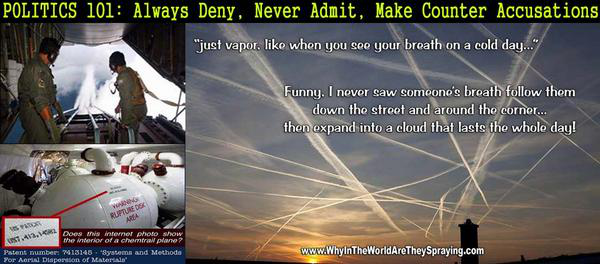

显示图片： media/3_456462992792498176.jpg


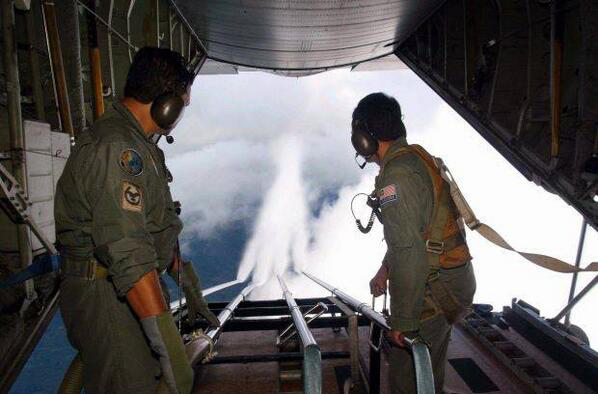

显示图片： media/3_512057468130979840.jpg


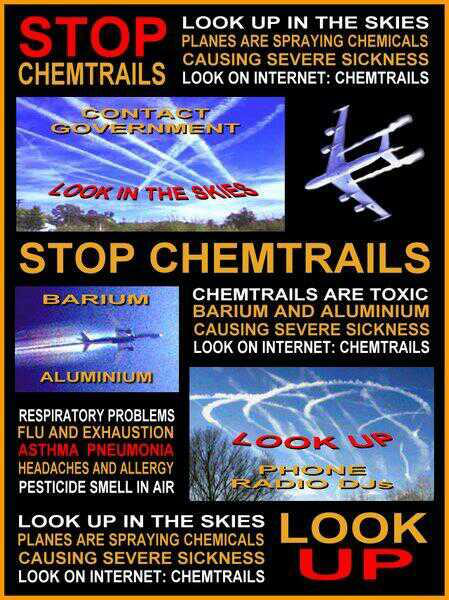

In [55]:
import zipfile
from PIL import Image
from IPython.display import display

ZIP_PATH = DATA_DIR / "media.zip"

def show_images_from_zip(media_df, n=3, start=0):
    with zipfile.ZipFile(ZIP_PATH, 'r') as z:
        for fname in media_df["image_file"].iloc[start:start+n]:
            full_path = f"media/{fname}"        # ⭐关键修复：补路径
            try:
                with z.open(full_path) as f:
                    img = Image.open(f).convert("RGB")
                    print("显示图片：", full_path)
                    display(img)
            except KeyError:
                print("❌ 找不到文件：", full_path)

show_images_from_zip(media_df, n=3, start=0)


In [ ]:
# 合并图片数据集 和 merged 合并
final_df = merged.merge(
    media_df,
    on="image_file",   # merged 的文件名（带 jpg）
    how="inner"
)

print("最终有效图片数量:", len(final_df))
print(final_df['Type'].value_counts())
final_df.head()


最终有效图片数量: 2951
Type
Business actors      2172
Scientific actors     779
Name: count, dtype: int64


image_file             media_key                  id  \
0  3_474839307350728704.jpg  3_474839307350728704  674953179365294082   
1  3_657882574338048001.jpg  3_657882574338048001  674876637025054720   
2  3_664051360032235521.jpg  3_664051360032235521  671344441089634305   
3  3_664051360032235521.jpg  3_664051360032235521  671272489452879872   
4  3_664086251616735232.jpg  3_664086251616735232  672360907494715392   

   author_id                                               text  \
0  453893556  #UNFAO success stories: Gaining traction on #c...   
1  453893556  Tools for integrating gender in project &amp; ...   
2  417856150  An ambitious deal at #COP21 is the 1st step to...   
3  417856150  #BackClimateAction to limit heatwaves, water s...   
4  417856150  Why we need #cities to #BackClimateAction - bl...   

                 created_at lang               Type Lang   Stance  
0  2015-12-10T14:05:52.000Z   en  Scientific actors   en  Unclear  
1  2015-12-10T09:01:43.000Z   en  Scientific actors   en  Unclear  
2  2015-11-30T15:06:02.000Z   en  Scientific actors   en      For  
3  2015-11-30T10:20:07.000Z   en  Scientific actors   en      For  
4  2015-12-03T10:25:06.000Z   en  Scientific actors   en      For

显示图片： media/3_667434394227970048.jpg


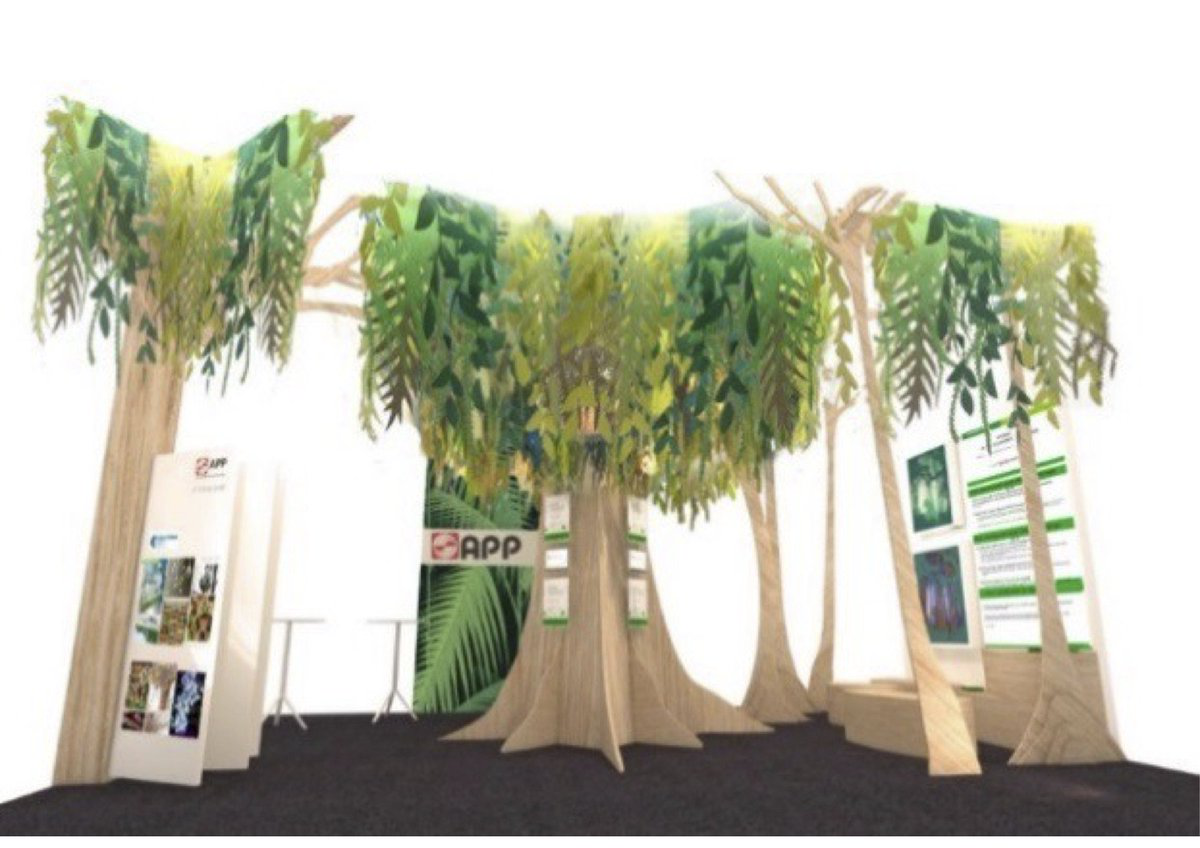

显示图片： media/3_668015403617165312.jpg


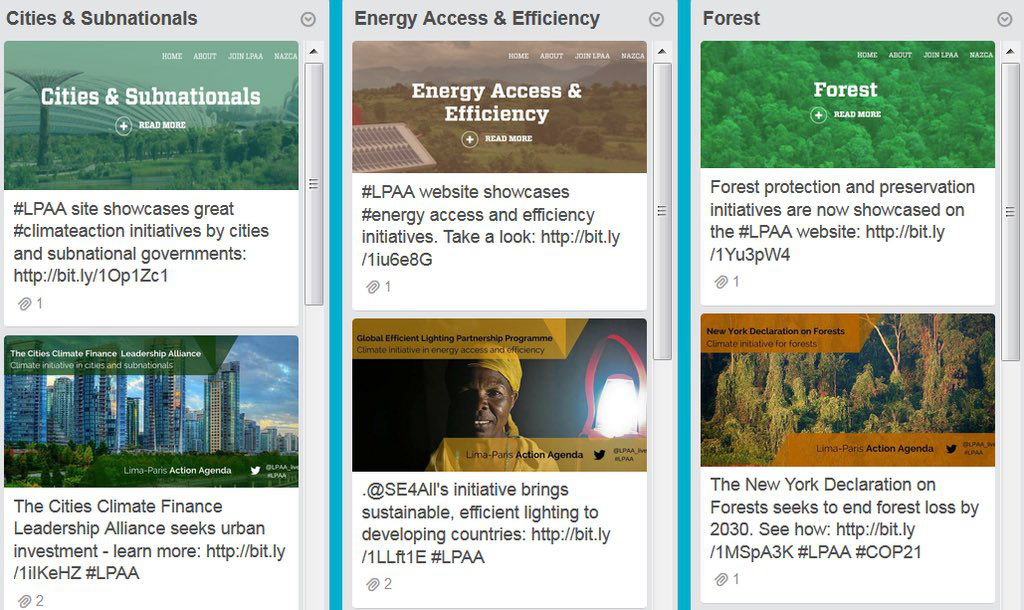

In [82]:
# 显示商业部分图片
show_images_from_zip(final_df[final_df["Type"] == "Business actors"], n=2, start=0)

显示图片： media/3_474839307350728704.jpg


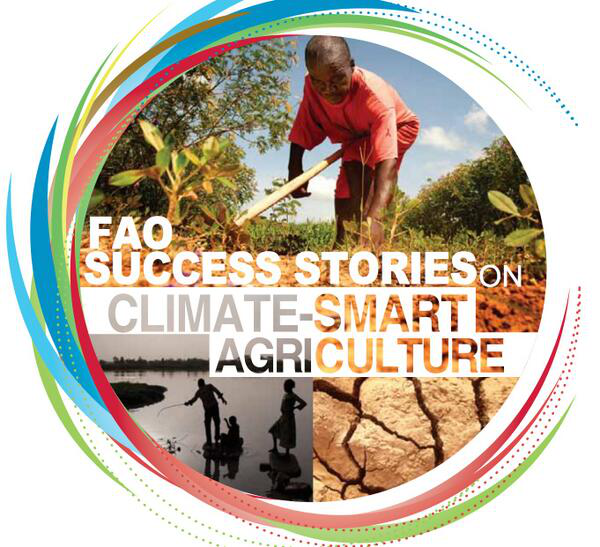

显示图片： media/3_657882574338048001.jpg


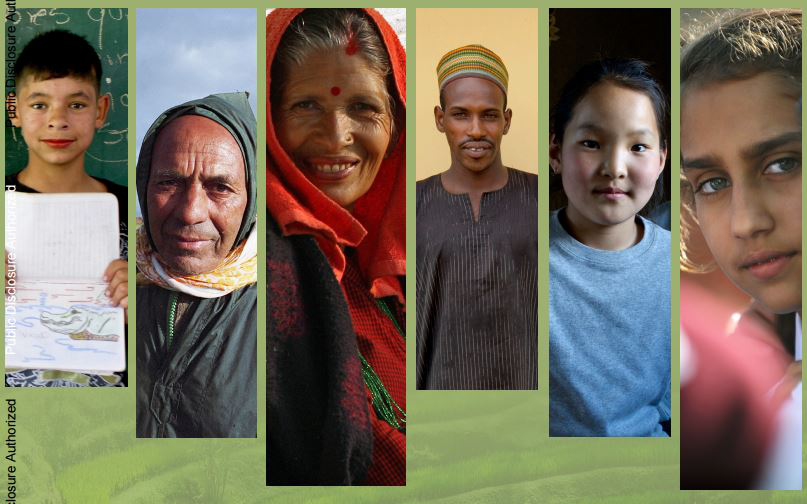

In [83]:
# 显示科学部分图片
show_images_from_zip(final_df[final_df["Type"] == "Scientific actors"], n=2, start=0)

In [84]:
import zipfile
import pandas as pd

# === 1. 路径设置 ===
ZIP_PATH = r"D:/uppsala/16. data of social mining/data/media.zip"  # 你的图片在这个ZIP中
OUTPUT_ZIP = "my_dataset.zip"

# === 2. 加载 final_df ===
df = final_df

if "image_file" not in df.columns:
    raise ValueError("final_df 中找不到 image_file 列！")

print("需要打包的图片数量:", len(df))

# === 3. 创建输出 ZIP ===
with zipfile.ZipFile(OUTPUT_ZIP, "w", compression=zipfile.ZIP_DEFLATED) as out_zip:

    # 写入 final_df
    df.to_csv("final_df_for_zip.csv", index=False, encoding="utf-8")
    out_zip.write("final_df_for_zip.csv", arcname="final_df.csv")

    # 打开原始 media.zip
    with zipfile.ZipFile(ZIP_PATH, "r") as media_zip:
        namelist = media_zip.namelist()

        count = 0

        for fname in df["image_file"]:
            # ZIP 内部真实路径是 media/xxxx.jpg
            zip_path = f"media/{fname}"

            if zip_path in namelist:
                # 读取原始ZIP的图片内容
                data = media_zip.read(zip_path)
                # 写入输出ZIP
                out_zip.writestr(f"images/{fname}", data)
                count += 1
            else:
                print("⚠ 找不到图片：", zip_path)

print(f"打包完成！成功添加 {count} 张图片。")
print(f"输出文件: {OUTPUT_ZIP}")


需要打包的图片数量: 2951


c:\Users\54241\anaconda3\envs\sda\lib\zipfile.py:1541: UserWarning: Duplicate name: 'images/3_664051360032235521.jpg'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
c:\Users\54241\anaconda3\envs\sda\lib\zipfile.py:1541: UserWarning: Duplicate name: 'images/3_669871365974056960.jpg'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
c:\Users\54241\anaconda3\envs\sda\lib\zipfile.py:1541: UserWarning: Duplicate name: 'images/3_671247319875063808.jpg'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
c:\Users\54241\anaconda3\envs\sda\lib\zipfile.py:1541: UserWarning: Duplicate name: 'images/3_671251656584126464.jpg'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
c:\Users\54241\anaconda3\envs\sda\lib\zipfile.py:1541: UserWarning: Duplicate name: 'images/3_671261167805943808.jpg'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
c:\Users\54241\anaconda3\envs\sda\lib\zipfile.py:1541: UserWarning: Duplicate name: 'images/3_67127310552

打包完成！成功添加 2951 张图片。
输出文件: my_dataset.zip


c:\Users\54241\anaconda3\envs\sda\lib\zipfile.py:1541: UserWarning: Duplicate name: 'images/3_675758905490874370.jpg'
  return self._open_to_write(zinfo, force_zip64=force_zip64)


In [77]:
import os
os.getcwd()


'd:\\uppsala\\16. data of social mining\\Social-data-mining\\Lab5_Image_analysis'

# Research Question:Do business and scientific actors use different distributions of image types
* e.g. people & events vs documents & graphs vs nature & climate impacts?